In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time
from sklearn.utils.extmath import randomized_svd


In [2]:
class Affine:
    def __init__(self,w,b):
        self.params = [w,b]
    def forward(self,x):
        W,b = self.params
        return np.dot(x,W) + b

class Sigmoid:
    def forward(self,x):
        return 1/(1+np.exp(-x))
    
def print_result(current, total, begin, end):
    lis = ['[' if i == 0 else ']' if i == 21 else ' ' for i in range(22)]
    index = int(current/total*20)
    percentage = format(current*100 / total, '.2f')
    if 0 <= index < 20:
        pass
    else:
        index = 20
    if index > 0:
        for i in range(1,index+1):
            lis[i] = u'\u25A0'
        string = ''.join(lis)
        time = end-  begin
        print(f'\r{string} {percentage}% Time: {time:.3f}s', end='', flush=True)
    else:
        string = ''.join(lis)
        time = end-  begin
        print(f'\r{string} {percentage}% Time: {time:.3f}s', end='', flush=True)


In [3]:
class Preprocess:
    def __init__(self, text: str, *args):
        dictionary = {i: f' {i}' for i in args}
        text = text.lower()
        for i in dictionary:
            text = text.replace(i, dictionary.get(i))
        self.text = text.split(' ')
        self.repeated = []
        
    def get_word_id(self):
        dictionary = {}
        dictionary2 = {}
        corpus = []
        append = corpus.append
        counter = 0
        for index, i in enumerate(self.text):
            if i not in dictionary:
                dictionary[i] = counter
                dictionary2[counter] = i
                counter += 1
                append(dictionary[i])
            else:
                self.repeated.append(index)
        return dictionary, dictionary2, corpus

    def get_single_context(self,id_word:dict, word_id:dict, corpus: list, word: str,window: int):  # list bound check
        text = self.text
        word = word.lower()
        length = len(text)
        if word not in text:
            return
        ls = [0] * len(corpus)
        for index, i in enumerate(text):
            if word_id[i] == word_id[word]:    
                if index == 0:
                    counter = 1
                    for k in range(window):
                        ls[counter] += 1
                        counter += 1
                elif index == length - 1:
                    counter = 1
                    for p in range(window):
                        ls[-1-counter] += 1
                        counter += 1
                else:
                    counter = counter2 = 1
                    word1_id = word_id[text[index - counter]]
                    word2_id = word_id[text[index + counter2]]
                    for p in range(window):
                        ls[word1_id] += 1
                        ls[word2_id] += 1
                        counter += 1
                        counter2 += 1
                        
        return np.array(ls)

    def get_coocurrenceMatrix(self,corpus: list,id_word: dict, word_id: dict, window:int):
        ls = []
        append = ls.append
        total = len(word_id)
        begin = time()
        for index, i in enumerate(word_id):
            append(self.get_single_context(id_word, word_id, corpus, i, window))
            print_result(index+1, total, begin, time())
        return np.array(ls), ls
    
def most_similar(matrix:list, word:str,word_id:dict, top:int):
    word = word.lower()
    if word not in word_id:
        return
    word_use_vector = matrix[word_id[word]]
    ls = {id_word[index]:similarity(word_use_vector, i) for index, i in enumerate(matrix) if index is not word_id[word]}
    return sorted(ls.items(),key=lambda x:x[1],reverse=True)[:top]
        
def similarity(vect1, vect2):
    x = vect1/(np.sqrt(np.sum(vect1**2)) + 1e-8)
    y = vect2/(np.sqrt(np.sum(vect2**2)) + 1e-8)
    return np.dot(x,y)

with open('ptb.train.txt', mode="r") as fp:
        string = fp.read()
preprocessed = Preprocess(string, ',', '.')
word_id, id_word, corpus = preprocessed.get_word_id()
cooccurrence_matrix, matrix_list = preprocessed.get_coocurrenceMatrix(
    corpus, id_word, word_id, 1)




[■■■■■■■■■■■■■■■■■■■■] 100.00% Time: 833.270s

In [42]:
def PPMI(co_matrix, corpus, verbose=True):
    ppmi_matrix = np.zeros_like(co_matrix, dtype=np.float32)
    N = np.sum(co_matrix)
    sigle_word = np.sum(co_matrix, axis = 0)
    total = co_matrix.shape[0]*co_matrix.shape[1]
    cols = co_matrix.shape[1]
    cnt = 0
    begin = time()
    for i in range(co_matrix.shape[0]):
        for j in range(co_matrix.shape[1]):
            ppmi = np.log2(co_matrix[i,j]*N/(sigle_word[i]*sigle_word[j]) + 1e-8)
            ppmi_matrix[i,j] = max(0, ppmi)
            if verbose:
                cnt += 1
                if cnt % (total//100+1) == 0:
                    print_result(cnt+1,total, begin, time())
    return ppmi_matrix
ppmi = PPMI(cooccurrence_matrix, corpus)

C:\Users\123\AppData\Local\Temp\ipykernel_13044\3934193267.py:11: RuntimeWarning: overflow encountered in long_scalars
  ppmi = np.log2(co_matrix[i,j]*N/(sigle_word[i]*sigle_word[j]) + 1e-8)
C:\Users\123\AppData\Local\Temp\ipykernel_13044\3934193267.py:11: RuntimeWarning: invalid value encountered in log2
  ppmi = np.log2(co_matrix[i,j]*N/(sigle_word[i]*sigle_word[j]) + 1e-8)


[■■■■■■■■■■■■■■■■■■■ ] 99.00% Time: 314.977s

In [25]:
U,S,V = randomized_svd(ppmi, n_components=100, n_iter=5,random_state=None)
U[0, :2]
U

array([[ 3.1707481e-10,  3.3681815e-07,  4.0746872e-07, ...,
        -2.1104420e-06,  4.5592725e-07, -1.5857007e-06],
       [ 2.9022987e-11,  1.7053791e-08, -1.6358539e-08, ...,
         7.3105082e-07,  2.9340379e-06, -2.8771435e-06],
       [ 7.3731308e-12, -2.7782994e-09, -1.2323197e-07, ...,
        -4.1778053e-06,  1.8882437e-07,  1.5046800e-06],
       ...,
       [ 5.4546371e-03, -9.1701625e-03,  4.3048002e-03, ...,
        -1.2796047e-03,  5.1282910e-03, -7.4147563e-03],
       [ 2.6714292e-03, -6.3869637e-03,  8.3345091e-03, ...,
         4.7574486e-03,  1.1937259e-03,  9.0463627e-03],
       [ 3.9116042e-03, -7.3255147e-03,  8.7847272e-03, ...,
        -3.2729760e-04, -2.8748219e-03, -4.0622004e-03]], dtype=float32)

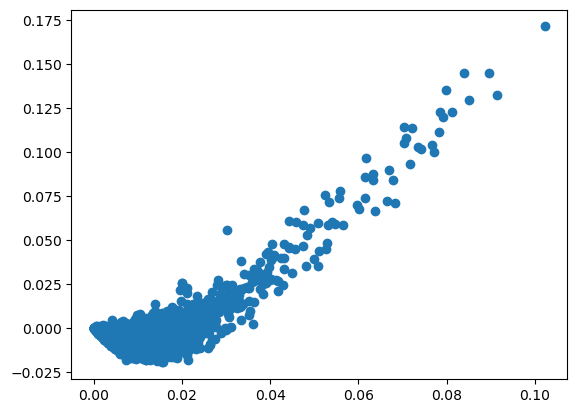

In [44]:
for i in id_word:
    plt.annotate(None, (U[i][0], U[i][1]))
plt.scatter(U[:, 0], U[:, 1])


In [43]:
most_similar(cooccurrence_matrix,'drive',word_id,top=10)

[('drive', 0.9999999993318469),
 ('join', 0.8468773437675046),
 ('prevent', 0.8421647526831304),
 ('accept', 0.8299926096800301),
 ('pass', 0.8280148478323421),
 ('handle', 0.8279468116570649),
 ('avoid', 0.8275560805557627),
 ('play', 0.8273075551144803),
 ('improve', 0.8269911346467299),
 ('bring', 0.8265948408803923)]